In [25]:
import pandas as pd
import numpy as np
import numpy.typing as npt

# from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from matplotlib import pyplot as plt

from tqdm import tqdm

from utility.types import RebalanceFrequencyEnum, AllocationMethodsEnum

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression


from data.universe import Universe

from data.benchmark import Benchmark


from backtest.backtest import Backtester

In [75]:
bench = Benchmark()
# universe = Universe.get_universe_returns()
# universe
benchmark = bench.get_benchmark_returns_data()
benchmark

,OISESTR,SPX,SX5T
Date,,,
2019-10-01,-0.000022,0.000000,0.000000
2019-10-02,-0.000022,-0.017903,-0.029827
2019-10-03,-0.000022,0.007972,0.001189
2019-10-04,-0.000022,0.014217,0.008586
2019-10-07,-0.000022,-0.004478,0.007117
...,...,...,...
2024-02-09,0.000155,0.000000,0.000000
2024-02-12,0.000155,0.004788,0.007551
2024-02-13,0.000155,-0.013674,-0.012024


In [88]:
HMM = MarkovRegression(
    endog=benchmark.SPX,
    k_regimes=2,
    exog=benchmark[["SX5T", "OISESTR"]],
    freq="B",
    trend="n",
    # switching_variance=True,
)
HMM_RESULT = HMM.fit()
HMM_RESULT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    SPX   No. Observations:                 1143
Model:               MarkovRegression   Log Likelihood                3653.255
Date:                Sun, 03 Mar 2024   AIC                          -7292.510
Time:                        18:15:44   BIC                          -7257.220
Sample:                    10-01-2019   HQIC                         -7279.185
                         - 02-15-2024                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SX5T           0.3503      0.047      7.472      0.000       0.258       0.442
OISESTR        1.4728      5.538      0.266      0.790      -9.382      12.327
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SX5T           1.0131      0.048     20.918      0.000       0.918       1.108
OISESTR        0.2241      7.664      0.029      0.977     -14.797      15.245
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.765e-05   4.03e-06     21.725      0.000    7.97e-05    9.56e-05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8114      0.097      8.377      0.000       0.622       1.001
p[1->0]        0.3092      0.150      2.058      0.040       0.015       0.604
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

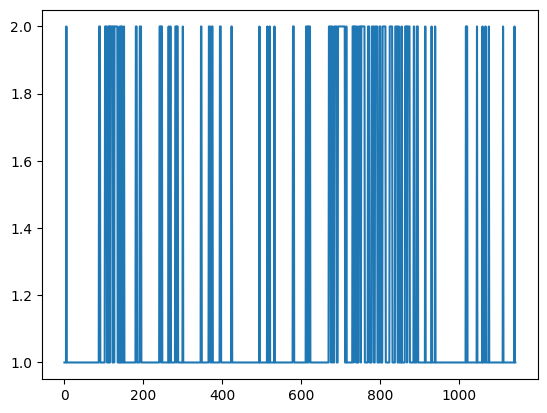

In [89]:
plt.plot(HMM_RESULT.smoothed_marginal_probabilities.values.argmax(axis=1)+1)

<Axes: title={'center': 'Probability of being in the high regime'}, xlabel='Date'>

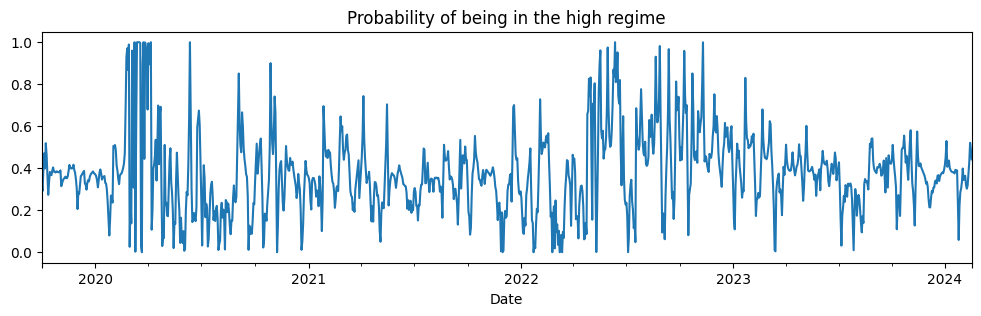

In [90]:
HMM_RESULT.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the high regime", figsize=(12, 3)
)

In [ ]:
def normalize_regime(signal: npt.NDArray[np.float128]) -> npt.NDArray[np.float128]:
    proportion = np.mean(signal)
    if proportion >= 0.5:
        return -1 * signal + 1
    return signal

In [ ]:
WITH_MEMORY = True
FIRST_TRAINED = False
STARTING_OFFSET = 500
EVERY = 300
VERBOSE = False
market["Regime_switch"] = 0
tot = STARTING_OFFSET


for row in tqdm(
    market.iloc[STARTING_OFFSET:].itertuples(index=True),
    desc="Training",
    total=market.iloc[STARTING_OFFSET:].shape[0],
    leave=False,
):
    data = market.loc[: row.Index]["EMA"].dropna()
    data_scaled = StandardScaler().fit_transform(data.to_numpy().reshape(-1, 1))
    if FIRST_TRAINED is False or tot % EVERY == 0:
        if VERBOSE is True:
            print(f"Retraining with data from {data.index[0]} to {data.index[-1]}")
        FIRST_TRAINED = True
        try:
            del model
        except:
            pass

        model = GaussianHMM(
            n_components=2, covariance_type="full", random_state=42, n_iter=100
        )
        model.fit(data_scaled)
    predicted = normalize_regime(model.predict(data_scaled))
    market.loc[row.Index, "Regime_switch"] = predicted[-1]
    tot += 1

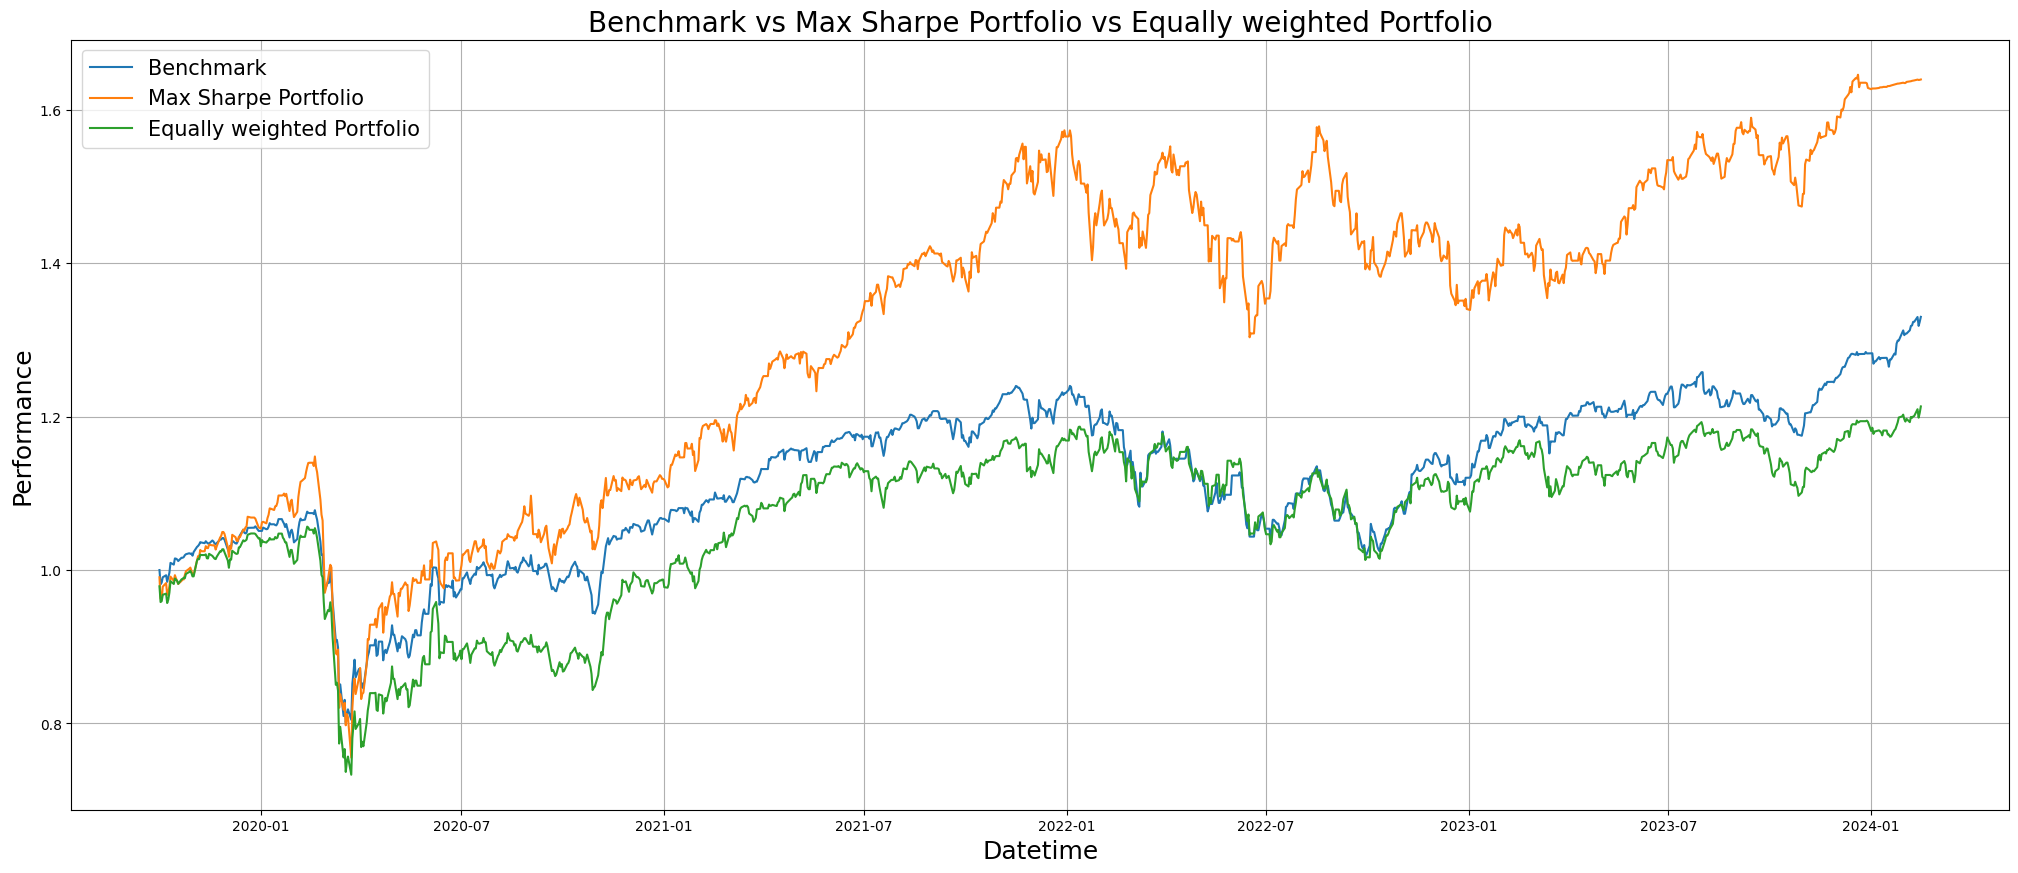

In [40]:
plt.figure(figsize=(25, 10))
plt.plot(ptf_and_bench_perf["benchmark_returns"], label="Benchmark")
plt.plot(ptf_and_bench_perf["ptf_returns_max_sharpe"], label="Max Sharpe Portfolio")
plt.plot(
    ptf_and_bench_perf["ptf_returns_equal_weight"], label="Equally weighted Portfolio"
)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Performance", fontsize=18)
plt.title(
    "Benchmark vs Max Sharpe Portfolio vs Equally weighted Portfolio",
    fontsize=20,
)
plt.grid()
plt.legend(fontsize=15)

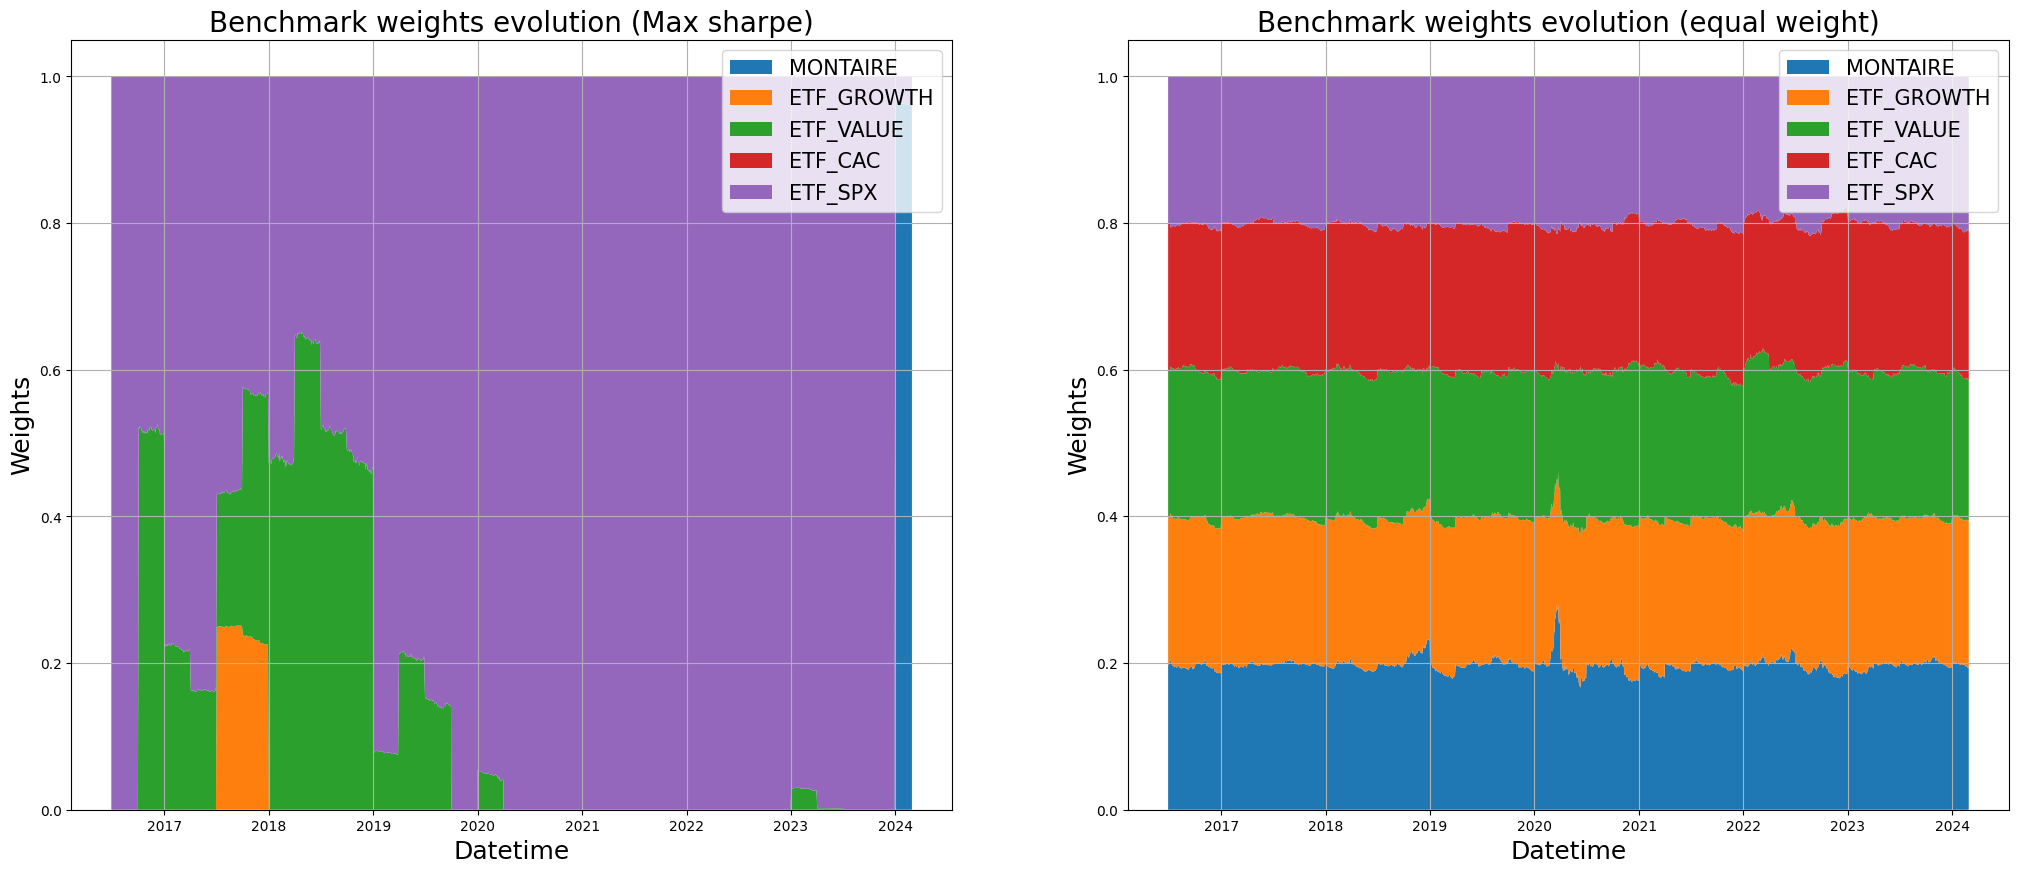

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

ax[0].stackplot(
    ptf_weights_max_sharpe.index,
    ptf_weights_max_sharpe.to_numpy().T,
)
ax[0].set_xlabel("Datetime", fontsize=18)
ax[0].set_ylabel("Weights", fontsize=18)
ax[0].set_title("Benchmark weights evolution (Max sharpe)", fontsize=20)
ax[0].grid()
ax[0].legend(ptf_weights_max_sharpe.columns.to_list(), fontsize=15)


ax[1].stackplot(
    ptf_weights_equal_weight.index,
    ptf_weights_equal_weight.to_numpy().T,
)
ax[1].set_xlabel("Datetime", fontsize=18)
ax[1].set_ylabel("Weights", fontsize=18)
ax[1].set_title("Benchmark weights evolution (equal weight)", fontsize=20)
ax[1].grid()
ax[1].legend(ptf_weights_equal_weight.columns.to_list(), fontsize=15)